# Reliability prediction of pulsar detection information

# Introduction:

Pulsars are a unique and fascinating class of objects known as neutron stars. These highly dense remnants of massive stars emit regular radio signals that can be detected from Earth. Pulsars fascinate astronomers and astrophysicists because of their potential to unlock mysteries about the fundamental properties of space-time, interstellar matter, and matter itself. But detecting pulsars requires sophisticated observational and analytical techniques. Detecting pulsars is challenging due to the presence of radio frequency interference (RFI) and noise, which makes it difficult to distinguish legitimate signals from spurious detections. We will try to predict whether the data has reference value from the data easily available in the table. The main question to be answered with this project is: Can we accurately classify pulsar candidates as real or spurious based on their observed characteristics?

### The eight continuous variables in the dataset are as follows:
* Mean of the integrated profile.
* Standard deviation of the integrated profile.
* Excess kurtosis of the integrated profile.
* Skewness of the integrated profile.
* Mean of the DM-SNR curve.
* Standard deviation of the DM-SNR curve.
* Excess kurtosis of the DM-SNR curve.
* Skewness of the DM-SNR curve.
* Class (0 for negative/spurious examples, 1 for positive/real pulsar examples)


library(tidyverse)
library(repr)
library(tidymodels)
library(ggplot2)

# Question: How would you classify them?

As shown below, the given table provides some data for pulsar candidates observed recently. However, the data only contains the statistics obtained from the integrated pulse profile. How would you predict and classify them based on dataset? 

In [105]:
Problem_data<-data.frame(
    mean_pf = c(135.34231, 152.21314, 19.02311, 30.31236),
    sd_pf = c(43.51234,52.97100,28.90231,30.23142),
    exkurtosis_pf = c(1.21343043,0.43125832,6.02134123,1.82321301),
    skewness_pf = c(-0.4135212,26.5231516,43.0453823,-0.1245083)
)
Problem_data

mean_pf,sd_pf,exkurtosis_pf,skewness_pf
<dbl>,<dbl>,<dbl>,<dbl>
135.34231,43.51234,1.2134304,-0.4135212
152.21314,52.97100,0.4312583,26.5231516
19.02311,28.90231,6.0213412,43.0453823
30.31236,30.23142,1.8232130,-0.1245083


# Preliminary exploratory data analysis:

In [92]:
HTRU<-read_csv("HTRU_2.csv",col_names=FALSE)
colnames(HTRU)=c("mean_pf",
                 "sd_pf",
                 "exkurtosis_pf",
                 "skewness_pf",
                 "mean_DM",
                 "sd_DM",
                 "exkurtosis_DM",
                 "skewness_DM",
                 "class")
HTRU<-HTRU|>
    mutate(class=as_factor(class))
head(HTRU)
#By previewing the data, we can see the data is already tidy.

Rows: 17898 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (9): X1, X2, X3, X4, X5, X6, X7, X8, X9

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


mean_pf,sd_pf,exkurtosis_pf,skewness_pf,mean_DM,sd_DM,exkurtosis_DM,skewness_DM,class
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
140.56250,55.68378,-0.23457141,-0.6996484,3.199833,19.11043,7.975532,74.24222,0
102.50781,58.88243,0.46531815,-0.5150879,1.677258,14.86015,10.576487,127.39358,0
103.01562,39.34165,0.32332837,1.0511644,3.121237,21.74467,7.735822,63.17191,0
136.75000,57.17845,-0.06841464,-0.6362384,3.642977,20.95928,6.896499,53.59366,0
88.72656,40.67223,0.60086608,1.1234917,1.178930,11.46872,14.269573,252.56731,0
93.57031,46.69811,0.53190485,0.4167211,1.636288,14.54507,10.621748,131.39400,0


In [49]:
HTRU_split <- initial_split(HTRU, prop = 0.75, strata = class)  
HTRU_train <- training(HTRU_split)   
HTRU_test <- testing(HTRU_split) #data spliting

Using only training data, summarize the data in at least one table (this is exploratory data analysis). An example of a useful table could be one that reports the number of observations in each class, the means of the predictor variables you plan to use in your analysis and how many rows have missing data. 

In [30]:
observations<-table(HTRU_train$class)
observations
#The number of observations for each class.


    0     1 
12180  1243 

In [33]:
rows_NA <- sum(!complete.cases(HTRU_train))
rows_NA
#There is no missing value in the dataset.

[1] 0

In [35]:
summary(HTRU_train[c("mean_pf","sd_pf","exkurtosis_pf","skewness_pf")])
#summary for each predictors

    mean_pf            sd_pf       exkurtosis_pf       skewness_pf     
 Min.   :  5.812   Min.   :24.79   Min.   :-1.73802   Min.   :-1.7919  
 1st Qu.:100.742   1st Qu.:42.34   1st Qu.: 0.02656   1st Qu.:-0.1854  
 Median :115.008   Median :46.93   Median : 0.22441   Median : 0.2015  
 Mean   :110.987   Mean   :46.52   Mean   : 0.48177   Mean   : 1.7833  
 3rd Qu.:127.035   3rd Qu.:50.96   3rd Qu.: 0.47816   3rd Qu.: 0.9515  
 Max.   :190.422   Max.   :98.78   Max.   : 8.06952   Max.   :68.1016  

Using only training data, visualize the data with at least one plot relevant to the analysis you plan to do (this is exploratory data analysis). An example of a useful visualization could be one that compares the distributions of each of the predictor variables you plan to use in your analysis.

In [54]:
#choose predictors
HTRU_visualization<-select(HTRU_train,mean_pf,sd_pf,exkurtosis_pf,skewness_pf,class)

In [51]:
HTRU_long <- gather(HTRU_visualization, key = "vars", value = "value",-class)
head(HTRU_long)

class,vars,value
<fct>,<chr>,<dbl>
0,mean_pf,102.50781
0,mean_pf,103.01562
0,mean_pf,88.72656
0,mean_pf,93.57031
0,mean_pf,119.48438
0,mean_pf,130.38281


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



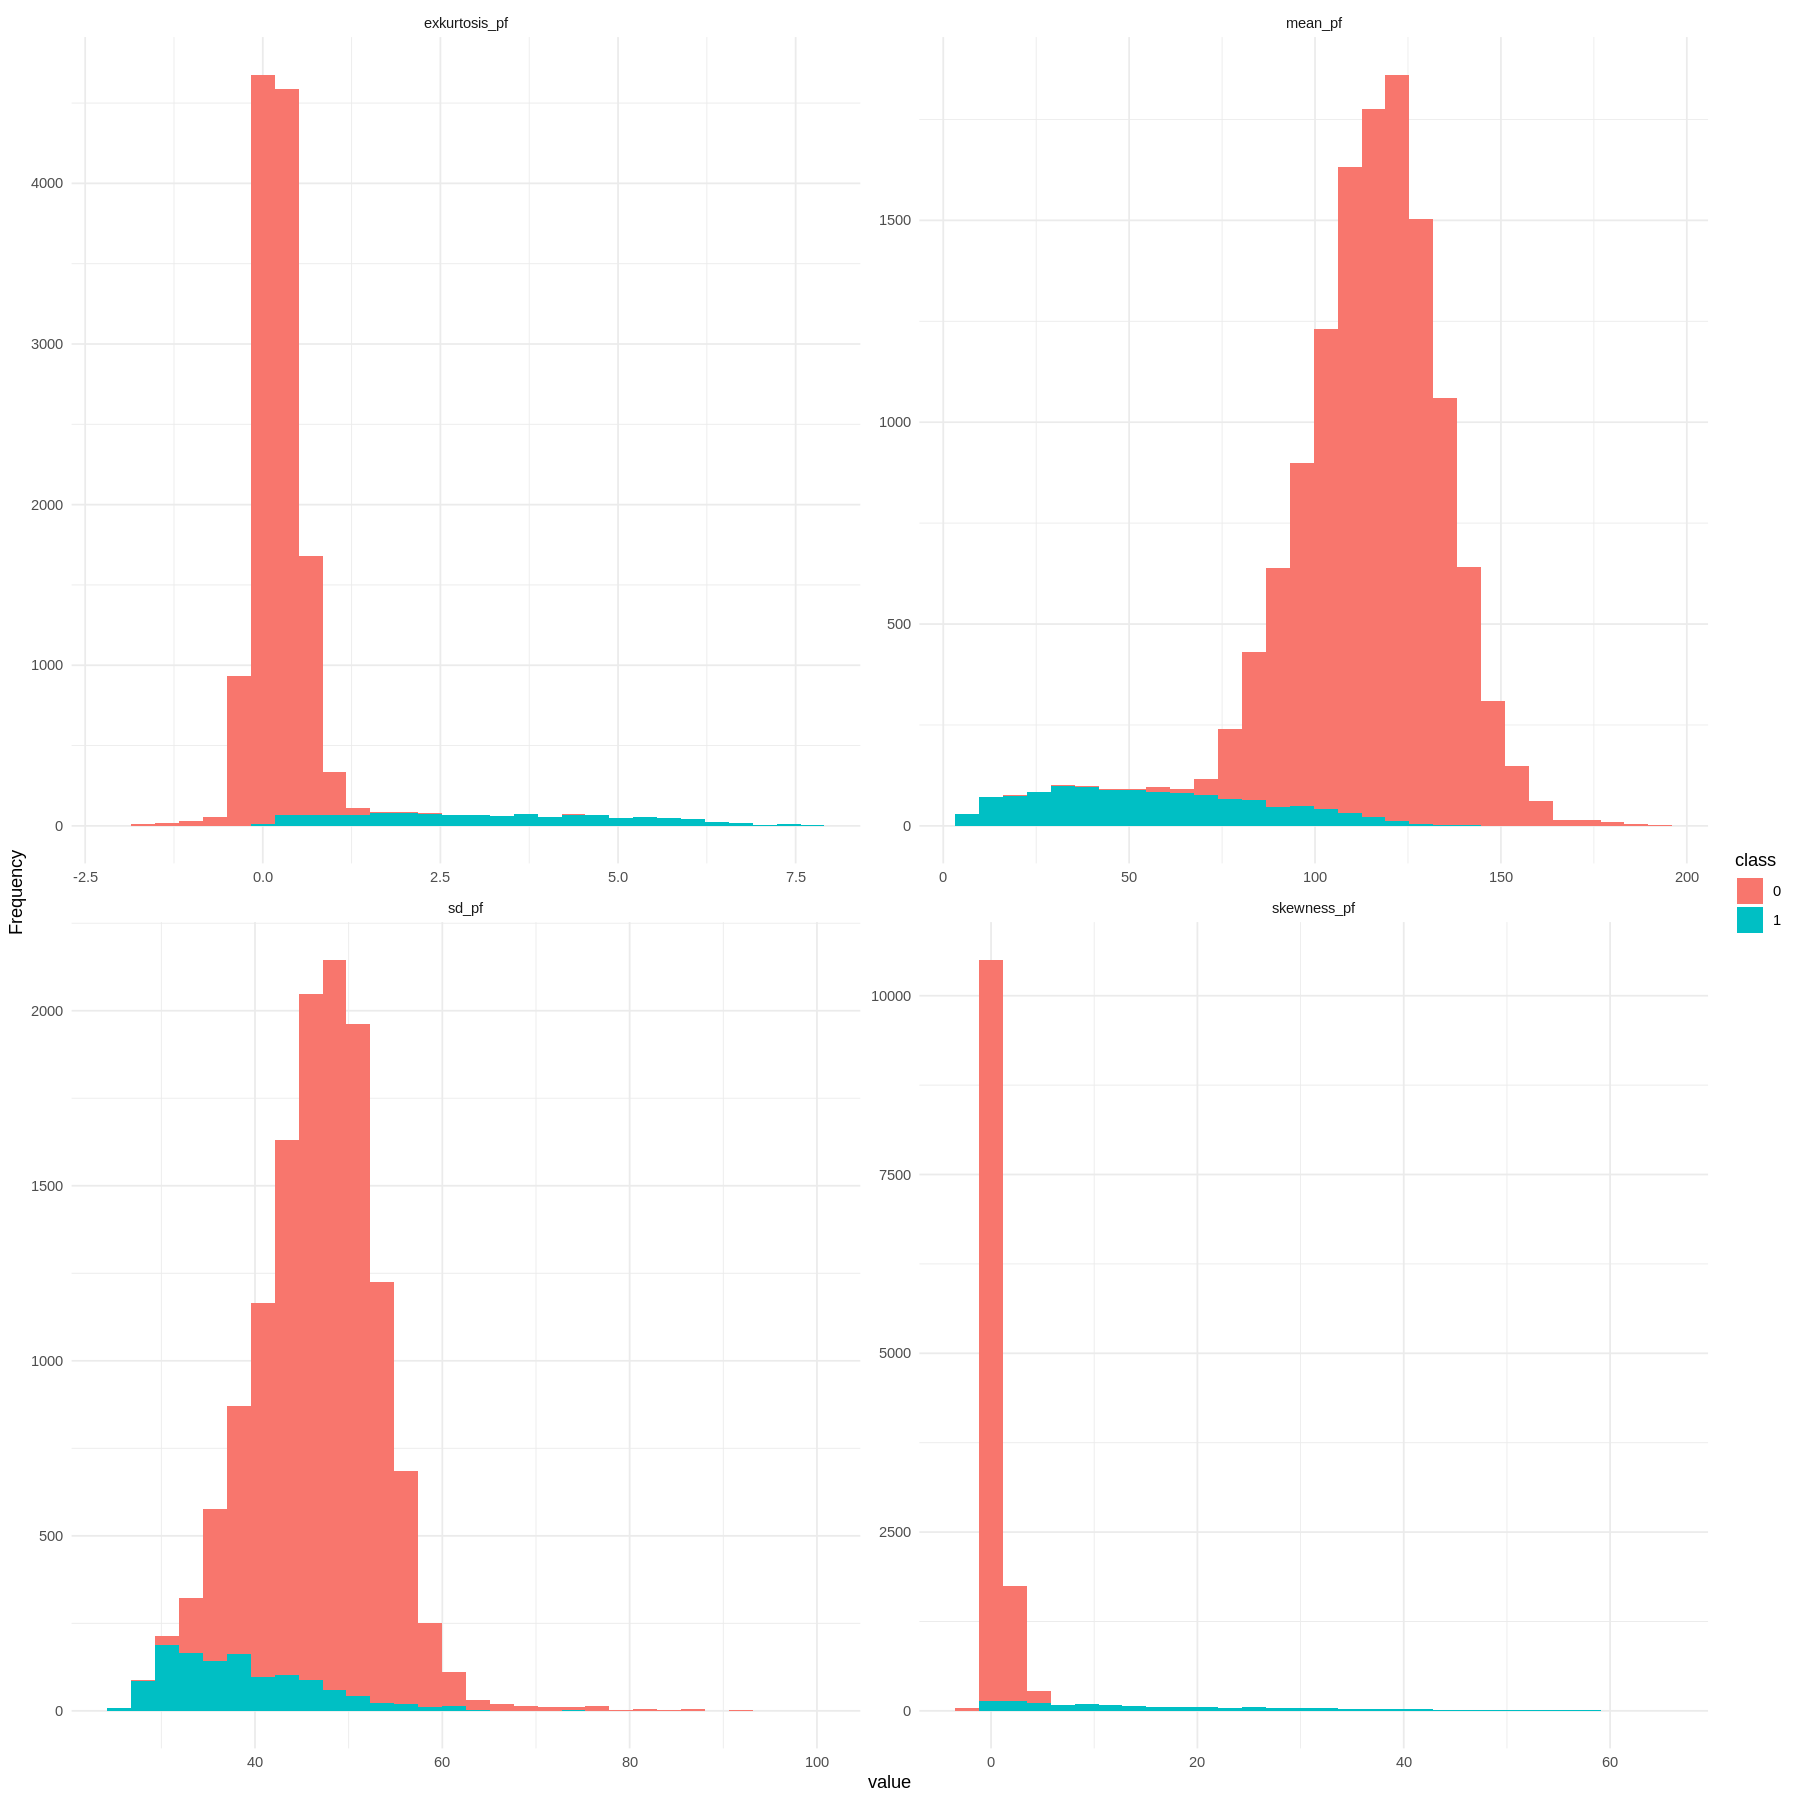

In [78]:
#visualization variables by class profile.
options(repr.plot.width = 15, repr.plot.height = 15)
HTRU_plot<-ggplot(HTRU_long,aes(x=value,fill=class))+
    geom_histogram()+
    facet_wrap(~ vars, scales = "free") +
    xlab("value")+
    ylab("Frequency")+
    theme(text = element_text(size = 30))+
    theme_minimal()
HTRU_plot

# Methods

All eight predictor variables in the data set are associated with predictions. However, since the first four first four are simple statistics obtained from comprehensive pulse profiles (folded profiles), they are more in line with the meaning of the project.

One way to visualize the results is to create scatter plot matrices or paired plots using the ggplot2 package. The plot will show the pair relationship between the predictors of each type (true pulsar and pseudo pulsar) and their distributions. It can help identify any patterns, correlations, or differences in the distribution between classes. It helps us to tell the real from the fake.

In [58]:
#recipe
HTRU_recipe <- recipe(class ~ mean_pf + sd_pf+ exkurtosis_pf + skewness_pf , data = HTRU_train) |>
    step_scale(mean_pf,sd_pf,exkurtosis_pf,skewness_pf) |>
    step_center(mean_pf,sd_pf,exkurtosis_pf,skewness_pf)
HTRU_recipe

Recipe

Inputs:

      role #variables
   outcome          1
 predictor          4

Operations:

Scaling for mean_pf, sd_pf, exkurtosis_pf, skewness_pf
Centering for mean_pf, sd_pf, exkurtosis_pf, skewness_pf

In [59]:
#model
knn_tune<-nearest_neighbor(weight_func="rectangular", neighbors=tune())|>
    set_engine("kknn")|>
    set_mode("classification")
knn_tune

K-Nearest Neighbor Model Specification (classification)

Main Arguments:
  neighbors = tune()
  weight_func = rectangular

Computational engine: kknn 


In [65]:
HTRU_vfold <- vfold_cv(HTRU_train, v = 10, strata = class)
HTRU_results <- workflow() |>
       add_recipe(HTRU_recipe) |>
       add_model(knn_tune) |>
       tune_grid(resamples = HTRU_vfold, grid = 10) |>
       collect_metrics()
HTRU_results

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
2,accuracy,binary,0.9653578,10,0.0014237152,Preprocessor1_Model1
2,roc_auc,binary,0.9222442,10,0.0055188169,Preprocessor1_Model1
3,accuracy,binary,0.9765328,10,0.0011608956,Preprocessor1_Model2
3,roc_auc,binary,0.9325912,10,0.0062136390,Preprocessor1_Model2
5,accuracy,binary,0.9778739,10,0.0008816267,Preprocessor1_Model3
5,roc_auc,binary,0.9379418,10,0.0057886910,Preprocessor1_Model3
8,accuracy,binary,0.9782464,10,0.0010163530,Preprocessor1_Model4
8,roc_auc,binary,0.9433429,10,0.0060522032,Preprocessor1_Model4
11,accuracy,binary,0.9791404,10,0.0009991425,Preprocessor1_Model5


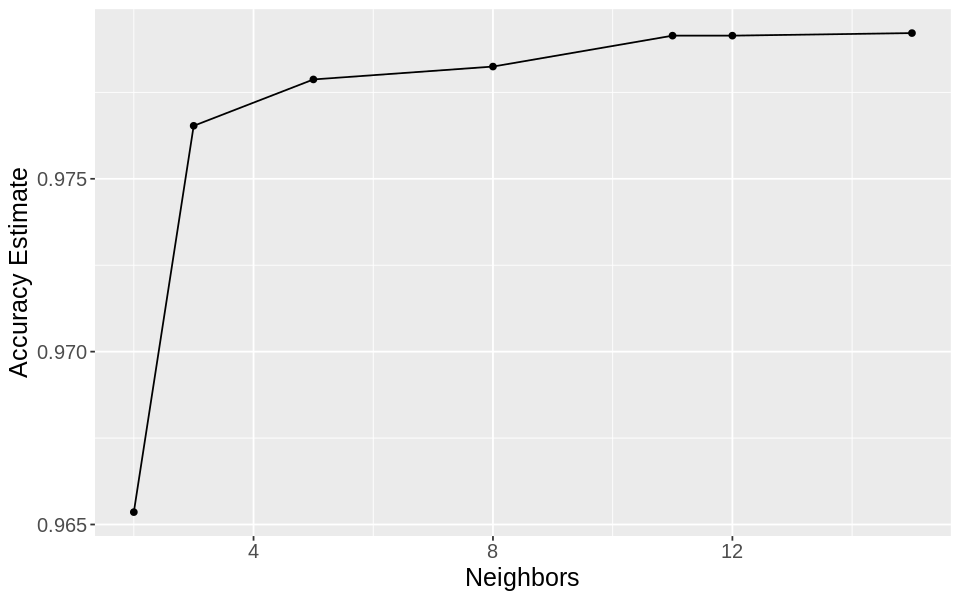

In [79]:
options(repr.plot.width = 8, repr.plot.height = 5)
accuracy<-HTRU_results|>
    filter(.metric=="accuracy")
accuracy_plot<-ggplot(accuracy,aes(x=neighbors,y=mean))+
  geom_point() +
  geom_line() +
  labs(x = "Neighbors", y = "Accuracy Estimate") + 
  theme(text = element_text(size = 15))
accuracy_plot
#Plot the accuray for different K neighbors

In [82]:
K_min <- accuracy |>
    arrange(desc(mean)) |> 
    slice(1)|>
    pull(neighbors)
K_min
#So we know K=15 gives us most accuracy.

[1] 15

In [87]:
HTRU_best_spec<-nearest_neighbor(weight_func="rectangular", neighbors=K_min)|>
    set_engine("kknn")|>
    set_mode("classification")

HTRU_fit<-workflow()|>
    add_recipe(HTRU_recipe)|>
    add_model(HTRU_best_spec)|>
    fit(data=HTRU_train)

HTRU_summary <- HTRU_fit |>
           predict(HTRU_test) |>
           bind_cols(HTRU_test)|>
           metrics(truth=class,estimate=.pred_class)
HTRU_summary   

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.9754190
kap,binary,0.8466468


From the table, we can see our model provides a high accuracy(97.5%) for prediction.

Now let's predict the data provided by question

In [106]:
HTRU_prediction<-HTRU_fit|>
    predict(Problem_data)|>
    bind_cols(Problem_data)
HTRU_prediction

.pred_class,mean_pf,sd_pf,exkurtosis_pf,skewness_pf
<fct>,<dbl>,<dbl>,<dbl>,<dbl>
0,135.34231,43.51234,1.2134304,-0.4135212
0,152.21314,52.97100,0.4312583,26.5231516
1,19.02311,28.90231,6.0213412,43.0453823
0,30.31236,30.23142,1.8232130,-0.1245083


By our prediction, we can see only third observation of pulsar is qualified, which are classified as 1, but all remaining are not.

### Expected outcomes and significance:

We expect to be able to easily distinguish between real and fake data by utilizing machine learning algorithms and providing data sets. The significance of accurately classifying pulsar data lies in its potential impact on accelerating large-scale pulsar investigation analysis. By automating the classification process, astronomers and researchers can focus on studying true pulsars, making more efficient use of telescope resources and improving our understanding of space-time, the interstellar medium, and the state of matter.

Future questions
* Can the classification model be strengthened to distinguish between different types of pulsars?
* Can the classification model be applied to other celestial object detection datasets to verify its validity and universality?
* Most of the data will be classified as 0, whether they can also provide some useful information?